## 1. Случайный вектор $(\xi_1, \xi_2, \xi_3, \xi_4, \xi_5, \eta)$ имеет компоненты, распределенные по следующему закону: $\xi_k \sim R(-1,1)$, $\eta \sim N(2 + 3x_1 - 2x_2 + x_3 + x_4 - x_5, 1.5^2)$, где $x_k$ это значения, которые принимает случайная величина $\xi_k$. Сгенерировать выборку объема $(n = 50)$.

In [32]:
import numpy as np
import pandas as pd

n = 50
np.random.seed(37)

xi1 = np.random.uniform(-1, 1, n)
xi2 = np.random.uniform(-1, 1, n)
xi3 = np.random.uniform(-1, 1, n)
xi4 = np.random.uniform(-1, 1, n)
xi5 = np.random.uniform(-1, 1, n)

eta_mean = 2 + 3*xi1 - 2*xi2 + xi3 + xi4 - xi5
eta = np.random.normal(eta_mean, 1.5, n)

data = pd.DataFrame({
    'ξ1': xi1,
    'ξ2': xi2,
    'ξ3': xi3,
    'ξ4': xi4,
    'ξ5': xi5,
    'η': eta
})

print(data.head())

         ξ1        ξ2        ξ3        ξ4        ξ5         η
0  0.888993  0.359403 -0.087548 -0.163211  0.860625  4.159835
1 -0.071804 -0.162041  0.221265  0.324508 -0.788372  3.048777
2 -0.614410  0.805717 -0.510013  0.961106 -0.425239 -0.837906
3  0.163790  0.890323  0.412355 -0.685125 -0.925995  1.271514
4  0.240168  0.954102  0.533532 -0.342739 -0.225371 -1.461054


### a. Проверить переменные \($\xi_k$\) на мультиколлинеарность.

In [33]:
import statsmodels.api as sm

X = data[['ξ1', 'ξ2', 'ξ3', 'ξ4', 'ξ5']]

for k in range(1,5 + 1):
    # Регрессия ξk на остальные переменные
    model = sm.OLS(X[f'ξ{k}'], sm.add_constant(X.drop(f'ξ{k}', axis=1))).fit()
    print(f'R² для ξ{k}: {model.rsquared:.3f}')


R² для ξ1: 0.034
R² для ξ2: 0.053
R² для ξ3: 0.052
R² для ξ4: 0.077
R² для ξ5: 0.007


Все значения $R^2$ на остальные переменные меньше 0.7, мультиколлинеарность отсутствует.
Это ожидаемо, так как переменные были сгенерированы независимо.

### b. Определить уравнение линейной регрессии: $\eta = \beta_0 + \sum_{k=1}^5 \beta_k \xi_k$ и проверить значимость коэффициентов.

In [34]:
from scipy.stats import t
import pandas as pd

PSI = sm.add_constant(X)

# Регрессия η
model = sm.OLS(data['η'], PSI).fit()
print(f'Params:\n{model.params}\n')

# Матрица Фишера
F = PSI.T @ PSI
F_inv = np.linalg.inv(F)

# RSS
RSS = model.ssr
print(f'RSS: {RSS:.4f}\n')

# Проверка значимости коэфф. регрессии
labels = ['const', 'ξ1', 'ξ2', 'ξ3', 'ξ4', 'ξ5']

sign_df = pd.DataFrame(columns = ['Параметр', 'Дельта', 'P-value', 'Итог'])
for k in range(len(labels)):
    delta = model.params[labels[k]] * np.sqrt(model.df_resid) / np.sqrt(RSS * F_inv[k][k])
    p_value = 2 * t.sf(np.abs(delta), model.df_resid)
    if (p_value < 0.05):
        sign_df.loc[k] = [labels[k], delta, p_value, 'Параметр значим']
    else:
        sign_df.loc[k] = [labels[k], delta, p_value, 'Параметр незначим']

print(sign_df)

Params:
const    1.829939
ξ1       3.129662
ξ2      -2.018171
ξ3       1.206193
ξ4       0.959783
ξ5      -0.665811
dtype: float64

RSS: 68.7728

  Параметр     Дельта       P-value             Итог
0    const  10.014811  6.382851e-13  Параметр значим
1       ξ1  10.265884  2.955549e-13  Параметр значим
2       ξ2  -6.055131  2.800255e-07  Параметр значим
3       ξ3   3.868255  3.582925e-04  Параметр значим
4       ξ4   2.766279  8.258493e-03  Параметр значим
5       ξ5  -2.194236  3.354312e-02  Параметр значим


### c. Определить коэффициент детерминации и проверить его значимость.

$$
\Delta \sim F(5, 44)
$$

In [35]:
from scipy.stats import f

print(f'Коэффициент детерминации: {model.rsquared:.4f}')

delta = (model.centered_tss - RSS) * (model.df_resid) / (RSS * (n - model.df_resid - 1))
p_value = f.sf(delta, n - model.df_resid - 1, model.df_resid)
print(f'Дельта: {delta:.4f}')
print(f'P-value: {p_value}')
if (p_value < 0.05):
    print('Коэффициент детерминации значим')
else:
    print('Коэффициент детерминации незначим')

Коэффициент детерминации: 0.8030
Дельта: 35.8706
P-value: 1.8538431446741047e-14
Коэффициент детерминации значим



### d. Найти значение в точке \($x_k$ = 0\) и построить 95% доверительный интервал.

In [36]:
y_wave = model.params['const']

X_0 = np.array([1, 0, 0, 0, 0, 0])

delta = t.ppf(1 - 0.05/2, model.df_resid) * np.sqrt(1 + X_0 @ F_inv @ X_0.T) * np.sqrt(RSS/model.df_resid)

print(f'Доверительный интервал: ({y_wave - delta:.4f}, {y_wave + delta:.4f})')

Доверительный интервал: (-0.7165, 4.3763)


### e. Проверить предположение о независимости ошибок измерения.

$H_0$: Ошибки измерения независимы и одинаковы распределены

$H_1: \overline H_0$

In [37]:
from scipy.stats import rankdata, norm

# Вектор ошибок
e = model.resid

def count_inversions(arr):
    ranks = rankdata(arr, method='average')  # Преобразуем в ранги
    inv_count = 0
    for i in range(len(ranks)):
        inv_count += np.sum(ranks[i+1:] < ranks[i])  # Считаем инверсии
    return int(inv_count)

delta = (count_inversions(e) - n * (n - 1) / 4) / np.sqrt((n ** 3) / 36)
p_value = 2*norm.sf(np.abs(delta), 0, 1)
print(f'Дельта: {delta:.4f}')  
print(f'P-value: {p_value:.4f}')
if (p_value < 0.05):
    print('Отвергаем H₀')
else:
    print('Нет оснований отвергать H₀')


Дельта: -1.0946
P-value: 0.2737
Нет оснований отвергать H₀



### f. Проверить предположение о нормальности распределения ошибок.

$H_0$: Ошибки измерения нормально распределены

$H_1: \overline H_0$

In [38]:
from statsmodels.stats.diagnostic import lilliefors

# Колмогоров для проверки сложной гипотезы
delta, p_value = lilliefors(e, dist='norm')
print(f'Дельта: {delta:.4f}')
print(f'P-value: {p_value:.4f}')
if (p_value < 0.05):
    print('Отвергаем H₀')
else:
    print('Нет оснований отвергать H₀')

Дельта: 0.0801
P-value: 0.5779
Нет оснований отвергать H₀


### g. Исследовать регрессию на выбросы.

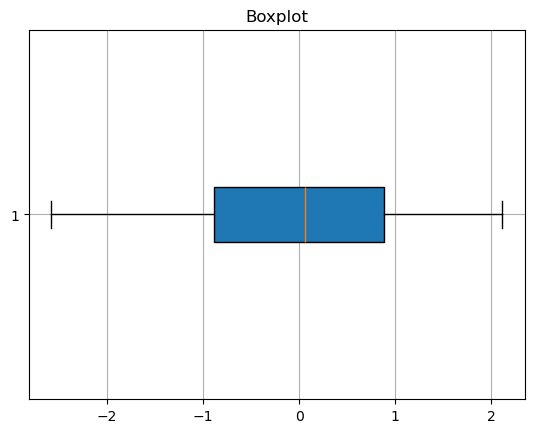

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot(e, vert=False, patch_artist=True, showfliers=True)
ax.set_title('Boxplot')
ax.axis('on')
ax.grid()
plt.show()

### h. Провести кросс-проверку регрессии.

In [40]:
CVSS = 0
for i in range(n):
    train_x = sm.add_constant(data.drop(i))[labels]
    train_y= sm.add_constant(data.drop(i)).η

    test_x = (sm.add_constant(data)[labels]).iloc[i]
    test_y = (sm.add_constant(data).η).iloc[i]

    model_n = sm.OLS(train_y, train_x).fit()
    y_wave = model_n.params.dot(test_x)

    CVSS += (y_wave - test_y) ** 2

print(f'CVSS: {CVSS}')
print(f'R² кросс-валидации: {(model.centered_tss - CVSS) / model.centered_tss}')

CVSS: 88.02040010156209
R² кросс-валидации: 0.7478683373138664


### i. Проверить адекватность регрессии, сделав 5 повторных измерений в одной точке.

$$
\tilde{\sigma}_1^2 = \frac{\sum_{i=1}^{n}{(y_i - \overline y)^2}}{l - 1}
$$

$$
\Delta \sim F(n - p, l - 1)
$$

In [41]:
point = [1, 0, 0, 0, 0, 0]
l = 5
eta_one_point = np.random.normal(2, 1.5, l)

y_mean = np.mean(eta_one_point)
sigma_sq_wave = np.sum((eta_one_point - y_mean) ** 2) / (l - 1)

delta = RSS / (model.df_resid * sigma_sq_wave)
p_value = f.sf(delta, model.df_resid, l - 1)
print(f'Дельта: {delta:.4f}')
print(f'P-value: {p_value:.4f}')
if (p_value < 0.05):
    print('Модель не адекватна')
else:
    print('Модель адекватна')


Дельта: 1.2836
P-value: 0.4552
Модель адекватна


### j. Удалить переменную, соответствующую наименее значимому коэфициенту и повторить пункты b и с, сравнить уравнения регрессии.

In [42]:
# ξ5 наименее значимый
X_dim = data[['ξ1', 'ξ2', 'ξ3', 'ξ4']]

PSI_dim = sm.add_constant(X_dim)

# Регрессия η
model_dim = sm.OLS(data['η'], PSI_dim).fit()
print(f'Params:\n{model_dim.params}\n')

# Матрица Фишера
F_dim = PSI_dim.T @ PSI_dim
F_inv_dim = np.linalg.inv(F_dim)

# RSS
RSS_dim = model_dim.ssr
print(f'RSS: {RSS_dim:.4f}\n')

# Проверка значимости коэфф. регрессии
labels_dim = ['const', 'ξ1', 'ξ2', 'ξ3', 'ξ4']

sign_df = pd.DataFrame(columns = ['Параметр', 'Дельта', 'P-value', 'Итог'])
for k in range(0, len(labels_dim)):
    delta = model_dim.params[labels_dim[k]] * np.sqrt(model_dim.df_resid) / np.sqrt(RSS_dim * F_inv_dim[k][k])
    p_value = 2 * t.cdf(-np.abs(delta), model_dim.df_resid)
    if (p_value < 0.05):
        sign_df.loc[k] = [labels[k], delta, p_value, 'Параметр значим']
    else:
        sign_df.loc[k] = [labels[k], delta, p_value, 'Параметр незначим']

print(sign_df)

Params:
const    1.818784
ξ1       3.136584
ξ2      -2.017867
ξ3       1.258317
ξ4       0.950920
dtype: float64

RSS: 76.2982

  Параметр    Дельта       P-value             Итог
0    const  9.560630  2.084318e-12  Параметр значим
1       ξ1  9.878935  7.605759e-13  Параметр значим
2       ξ2 -5.812850  5.915298e-07  Параметр значим
3       ξ3  3.885827  3.321133e-04  Параметр значим
4       ξ4  2.631646  1.159759e-02  Параметр значим



$$
\Delta \sim F(4, 45)
$$

In [43]:
from scipy.stats import f

print(f'Коэффициент детерминации: {model_dim.rsquared:.4f}')

delta = (model_dim.centered_tss - RSS_dim) * (model_dim.df_resid) / (RSS_dim * (n - model_dim.df_resid - 1))
p_value = f.sf(delta, n - model_dim.df_resid - 1, model_dim.df_resid)
print(f'Дельта: {delta:.4f}')
print(f'P-value: {p_value}')
if (p_value < 0.05):
    print('Коэффициент детерминации значим')
else:
    print('Коэффициент детерминации незначим')

Коэффициент детерминации: 0.7814
Дельта: 40.2247
P-value: 2.565470812987836e-14
Коэффициент детерминации значим


$$
H_0: \beta_i = 0, \forall i \in I
$$

$$
H_1: \exist i \in I: \beta_i \neq 0
$$


$$
\Delta = \frac{\frac{RSS_0 - RSS_1}{p_1 - p_0}}{\frac{RSS_1}{n - p_1}} \sim F(p_1 - p_0, n - p_1)
$$

In [44]:
delta = ((RSS_dim - RSS) * model.df_resid) / (RSS * (model_dim.df_resid - model.df_resid))
p_value = f.sf(delta, model_dim.df_resid - model.df_resid, model.df_resid)
print(f'Дельта: {delta:.4f}')
print(f'P-value: {p_value}')
if (p_value < 0.05):
    print('Отвергаем H₀')
else:
    print('Нет оснований отвергать H₀')

Дельта: 4.8147
P-value: 0.03354312011385344
Отвергаем H₀


### k. Сравнить уравнения регрессии бутстрапом.

In [45]:
# Количество повторений бутстрапа
n_iterations = 1000
beta = 0.95

# Оценка полученная ОМП
h_wave = model.rsquared - model_dim.rsquared
bootstrap_delta = []

for _ in range(n_iterations):
    sample = sm.add_constant(data.sample(n=n, replace=True))
    b_model = sm.OLS(sample.η, sample[labels]).fit()
    b_model_dim = sm.OLS(sample.η, sample[labels_dim]).fit()
    bootstrap_delta.append(b_model.rsquared - b_model_dim.rsquared - h_wave)

variation_row = sorted(bootstrap_delta)

t = variation_row[int((1 - beta) * n_iterations)]

lower_bound = h_wave - variation_row[-1]
upper_bound = h_wave - t

print(f'Доверительный интервал: ({lower_bound}, {upper_bound}), длина: {upper_bound - lower_bound}')
if (lower_bound * upper_bound > 0):
    print('Различие значимо')
else:
    print('Различие незначимо')

Доверительный интервал: (-0.05694347544597944, 0.04112820146148577), длина: 0.09807167690746521
Различие незначимо
